In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jsonlines

from tqdm import tqdm

In [79]:
# rv = []
# for obj in tqdm(jsonlines.open("../data/items_static_metadata.jl")):
#     rv.append(obj)
# item_metadata = pd.DataFrame(rv)

In [8]:
train_data = pd.read_parquet('../data/meli_train_data.parquet')

In [12]:
train_data

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.000000
...,...,...,...,...,...,...,...,...,...
37660274,129187,2021-03-31,0,22057.00,ARG,classic,drop_off,free_shipping,267.710767
37660275,6707,2021-03-31,0,26999.00,ARG,classic,cross_docking,free_shipping,266.083333
37660276,170355,2021-03-31,0,3400.00,ARG,classic,drop_off,paid_shipping,0.252633
37660277,246568,2021-03-31,0,6289.00,ARG,classic,fulfillment,free_shipping,135.416667


In [11]:
test_data = pd.read_csv('../data/meli_test_data.csv')
test_data

,sku,target_stock
0,464801,3
1,645793,4
2,99516,8
3,538100,8
4,557191,10
...,...,...
551467,129187,8
551468,6707,30
551469,170355,3
551470,246568,2


In [41]:
sku_list = train_data["sku"].unique()

In [87]:
sku_sample = np.random.choice(sku_list, 100, replace=False)

In [88]:
#for simplicity purposes let's take a small sample of sku from the data
train_data_sample = train_data.query("sku in @sku_sample")

In [89]:
train_data_sample["sold_quantity"].unique()

array([ 0,  1,  2,  3,  4,  6,  5,  8,  7, 12, 13,  9, 14, 16, 18, 10, 11,
       21, 19, 15, 27, 17, 29, 20, 22, 99, 34, 45, 23, 24, 55, 30, 31, 33,
       25, 41, 28, 26])

In [90]:
train_data_sample

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
212635,134647,2021-02-01,0,79.99,REA,classic,fulfillment,paid_shipping,1440.0
212636,134647,2021-02-02,1,76.79,REA,classic,fulfillment,paid_shipping,1440.0
212637,134647,2021-02-03,0,76.79,REA,classic,fulfillment,paid_shipping,1440.0
212638,134647,2021-02-04,0,76.79,REA,classic,fulfillment,paid_shipping,1440.0
212639,134647,2021-02-05,0,76.79,REA,classic,fulfillment,paid_shipping,1440.0
...,...,...,...,...,...,...,...,...,...
36768307,88138,2021-03-27,0,2200.00,ARG,classic,fulfillment,paid_shipping,0.0
36768308,88138,2021-03-28,0,2200.00,ARG,classic,fulfillment,paid_shipping,0.0
36768309,88138,2021-03-29,0,2200.00,ARG,classic,fulfillment,paid_shipping,0.0
36768310,88138,2021-03-30,0,2200.00,ARG,classic,fulfillment,paid_shipping,0.0


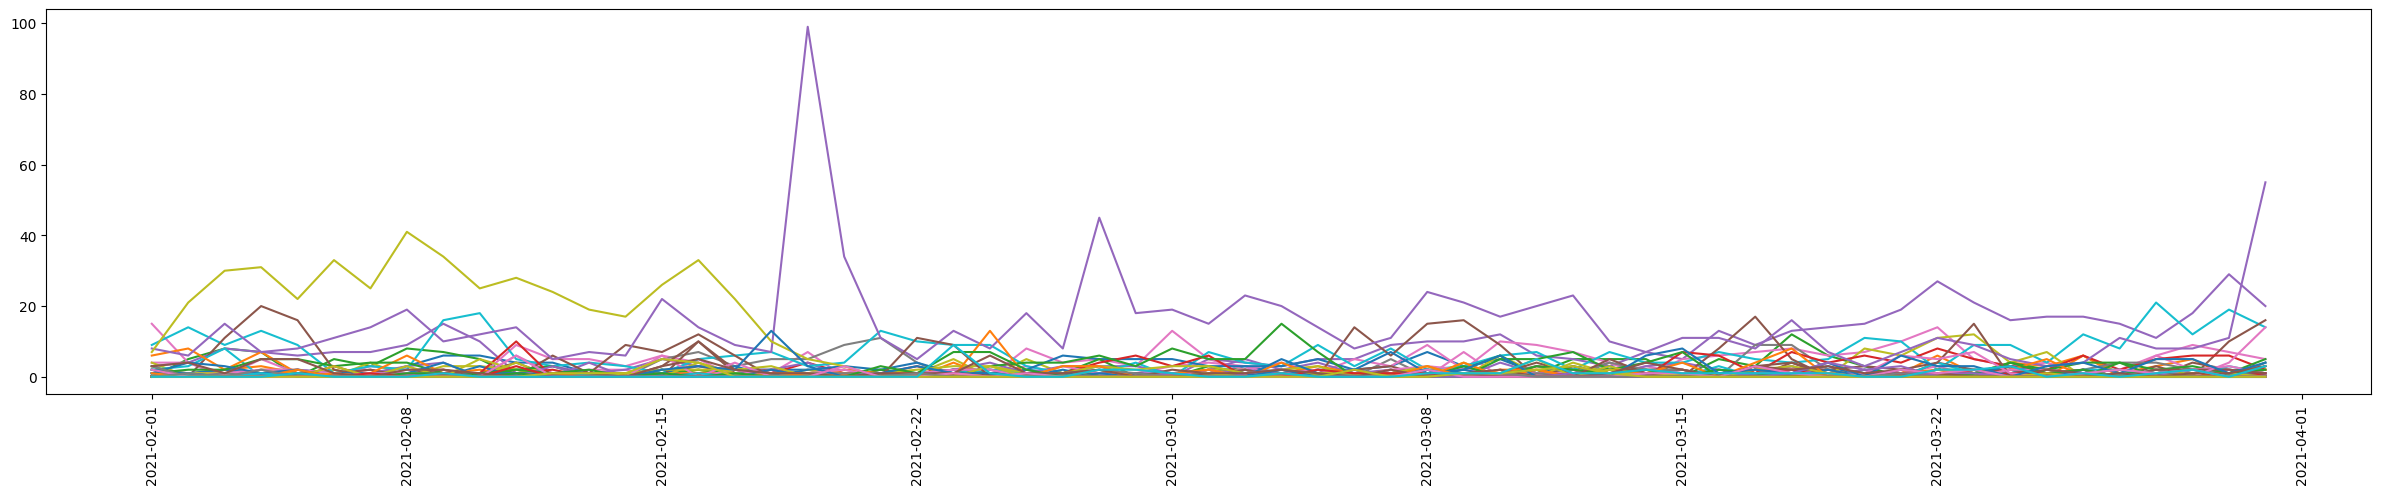

In [91]:
#let's see how sold_quantity is distributed over time for each sku
sold_quantity_by_sku_and_date = train_data_sample[["sku", "date", "sold_quantity"]].groupby(['sku', "date"]).sum().reset_index()

plt.figure(figsize=(30, 5))
#take all sku
for sku in sold_quantity_by_sku_and_date["sku"].unique():
    sold_quantity_by_sku = sold_quantity_by_sku_and_date.query("sku == @sku")
    sold_quantity_by_sku.loc[:, "date"] = pd.to_datetime(sold_quantity_by_sku["date"])
    sold_quantity_by_sku = sold_quantity_by_sku.sort_values(by="date")
    plt.plot(sold_quantity_by_sku["date"], sold_quantity_by_sku["sold_quantity"], label=sku)
plt.xticks(rotation=90)
plt.show()

strategy: explore data searching for groups (correlations between variables) to clasify each sku. Now, for each group, train a model to get the probability distribution of those items being sold within the next 30 days via bayes theorem

In [92]:
train_data_sample.columns

Index(['sku', 'date', 'sold_quantity', 'current_price', 'currency',
       'listing_type', 'shipping_logistic_type', 'shipping_payment',
       'minutes_active'],
      dtype='object')

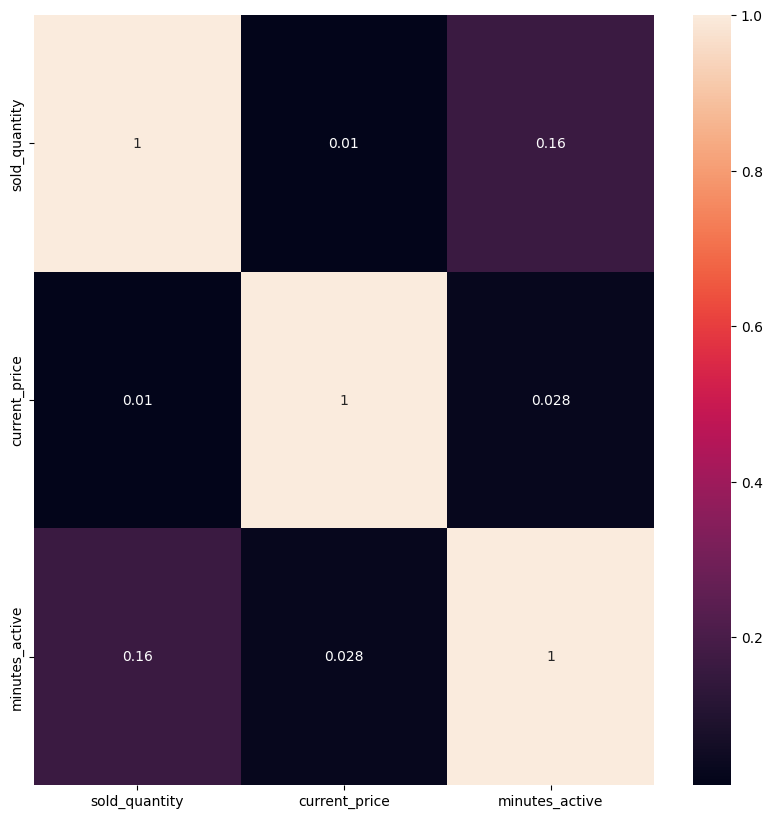

In [97]:
train_data_sample_corr = train_data_sample[["sold_quantity", "current_price", "minutes_active"]].corr()

#plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(train_data_sample_corr, annot=True)
plt.show()

In [98]:
# dates = train_data_sample["date"].unique()

# # create subplots for each date
# fig, axs = plt.subplots(nrows=len(dates), figsize=(15, 5*len(dates)))

# # plot scatterplot for each date
# for i, date in enumerate(dates):
#     train_data_sample_by_date = train_data_sample.query("date == @date")
#     axs[i].set_title(date)
#     axs[i].scatter(train_data_sample_by_date["sold_quantity"], train_data_sample_by_date["current_price"], c=train_data_sample_by_date["minutes_active"])
#     axs[i].set_xlabel("sold_quantity")
#     axs[i].set_ylabel("current_price")
#     fig.colorbar(axs[i].collections[0], ax=axs[i], label="minutes_active")

# plt.show()